# Building a drone using RxInfer.jl

In [1]:
using RxInfer, LinearAlgebra

## Defining structures

In [2]:
"""
    Environment(; gravitational_constant::Float64 = 9.81)

This structure contains the properties of the environment.
"""
Base.@kwdef struct Environment
    gravitational_constant::Float64 = 9.81
end
get_gravity(env::Environment) = env.gravitational_constant

get_gravity (generic function with 1 method)

In [3]:
"""
    Drone(mass, inertia, radius, force_limit)

This structure contains the properties of the drone.
"""
Base.@kwdef struct Drone
    mass::Float64
    inertia::Float64
    radius::Float64
    force_limit::Float64
end
get_mass(drone::Drone) = drone.mass
get_properties(drone::Drone) = (drone.mass, drone.inertia, drone.radius, drone.force_limit)

get_properties (generic function with 1 method)

In [4]:
"""
    State(x, y, vx, vy, 𝜃, 𝜔)

This structure contains the state of the drone. It contains the position, velocity, and orientation of the drone.
"""
struct State
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    𝜃::Float64
    𝜔::Float64
end
get_state(state::State) = (state.x, state.y, state.vx, state.vy, state.𝜃, state.𝜔)

get_state (generic function with 1 method)

## Model specification

In [5]:
"""
    state_transition(state, actions, drone, environment, dt)

This function computes the next state of the drone given the current state, the actions, the drone properties and the environment properties.
"""
function state_transition(state, actions, drone::Drone, environment::Environment, dt)

    # extract drone properties
    m, I, r, limit  = get_properties(drone)

    # extract environment properties
    g = get_gravity(environment)

    # extract feasible actions
    Fl, Fr   = clamp.(actions, 0, limit)
        
    # extract state properties
    x, y, vx, vy, θ, ω = state

    # compute forces and torques
    Fg = m * g
    Fy = (Fl + Fr) * cos(θ) - Fg
    Fx = (Fl + Fr) * sin(θ)
    𝜏  = (Fl - Fr) * r

    # compute movements
    ax = Fx / m
    ay = Fy / m
    vx_new = vx + ax * dt
    vy_new = vx + ay * dt
    x_new  = x + vx * dt + ax * dt^2 / 2
    y_new  = y + vy * dt + ay * dt^2 / 2
        
    # compute rotations
    α = 𝜏 / I
    ω_new = ω + α * dt
    θ_new = θ + ω * dt + α * dt^2 / 2
	
    return [x_new, y_new, vx_new, vy_new, θ_new, ω_new]

end

state_transition

In [6]:
@model function drone_model(drone::Drone, environment::Environment, initial_state, goal, horizon, dt)	

	# extract environment properties
	g = get_gravity(environment)

	# extract drone properties
	m = get_mass(drone)

	# initial state prior
	s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * I)

	for i in 1:horizon

		# prior on actions (mean compensates for gravity)
		F[i] ~ MvNormal(μ = [m * g / 2, m * g / 2], Σ = diageye(2))

		# state transition
		s[i + 1] ~ MvNormal(
            μ = state_transition(s[i], F[i], drone, environment, dt), 
			Σ = 1e-10 * I
		)
		# s[i + 1] ~ MvNormal(μ = goalM[i], Σ = goalV[i])
	end

	# s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * I) # ERROR (GraphPPL.jl)
	# s[horizon + 1] ~ MvNormal(mean = goal, covariance = 1e-5 * I) # ERROR (ExponentialFamily.jl)
	s[horizon + 1] ~ MvNormal(mean = goal, covariance = 1e-5 * diageye(6))

end

┌ Warning: Type annotation found in interface drone::Drone. While this will check that drone is an Drone, dynamic creation of submodels using multiple dispatch is not supported.
└ @ GraphPPL /Users/bartvanerp/Documents/PhD/DroneDemo/GraphPPL.jl/src/model_macro.jl:682
┌ Warning: Type annotation found in interface environment::Environment. While this will check that environment is an Environment, dynamic creation of submodels using multiple dispatch is not supported.
└ @ GraphPPL /Users/bartvanerp/Documents/PhD/DroneDemo/GraphPPL.jl/src/model_macro.jl:682


## Probabilistic inference

In [7]:
@meta function drone_meta()

	# approximate the state transition function using the Unscented transform
	state_transition() -> Unscented()

end

drone_meta (generic function with 1 method)

In [8]:
function move_to_target(drone::Drone, env::Environment, start::State, target, horizon, dt)

    results = infer(
        model = drone_model(
            drone = drone, 
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        data  = (
            initial_state = collect(get_state(start)), 
            goal = [target[1], target[2], 0, 0, 0, 0],
        ),
        meta  = drone_meta(),
        # options = (limit_stack_depth = 300, ),
        iterations = 1,
        returnvars = (s = KeepLast(), F = KeepLast())
    )

    return results

end

move_to_target (generic function with 1 method)

In [9]:
drone = Drone(
    mass = 1,
    inertia = 1,
    radius = 0.2,
    force_limit = 15.0
)

env = Environment()

start = State(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

target = [-0.8, 0.6]

results = move_to_target(drone, env, start, target, 40, 0.05)

Inference results:
  Posteriors       | available for (F, s)


## Plotting

In [10]:
using Plots

In [11]:
function plot_drone!(p, drone::Drone, state::State; color = :black)
    x, y, x_a, y_a, θ, ω = get_state(state)
    _, _, radius, _ = get_properties(drone)
    dx = radius * cos(θ)
    dy = radius * sin(θ)

    drone_position = [ x ], [ y ]
    drone_engines  = [ x - dx, x + dx ], [ y + dy, y - dy ]
    drone_coordinates = [ x - dx, x, x + dx ], [ y + dy, y, y - dy ]

    rotation_matrix = [ cos(-θ) -sin(-θ); sin(-θ) cos(-θ) ]
    engine_shape = [ -1 0 1; 1 -1 1 ]
    drone_shape  = [ -2 -2 2 2 ; -1 1 1 -1 ]
    
    engine_shape = rotation_matrix * engine_shape
    drone_shape  = rotation_matrix * drone_shape
    engine_marker = Shape(engine_shape[1, :], engine_shape[2, :])
    drone_marker  = Shape(drone_shape[1, :], drone_shape[2, :])
    
    scatter!(p, drone_position[1], drone_position[2]; color = color, label = false, marker = drone_marker)
    scatter!(p, drone_engines[1], drone_engines[2]; color = color, label = false, marker = engine_marker, ms = 10)
    plot!(p, drone_coordinates; color = color, label = false)

    return p
end

plot_drone! (generic function with 1 method)

In [12]:
function animate_drone(drone::Drone, target, results::InferenceResult)

    states = hcat(map(p -> mean(p), results.posteriors[:s])...)
    

    @gif for k in 1:size(states,2)

        # plot target
        p = scatter([target[1]], [target[2]], label = "target"; color = :red)

        # plot drone
        plot_drone!(p, drone, State(states[:, k]...))

        xlims!(-1.5, 1.5)
        ylims!(-1.5, 1.5)
    
    end

end

animate_drone (generic function with 1 method)

┌ Info: Saved animation to /var/folders/b1/n3y14z215kd8t8v0cptbk2980000gn/T/jl_56ni9SDsjo.gif
└ @ Plots /Users/bartvanerp/.julia/packages/Plots/a3u1v/src/animation.jl:156


Plots.AnimatedGif("/var/folders/b1/n3y14z215kd8t8v0cptbk2980000gn/T/jl_56ni9SDsjo.gif")
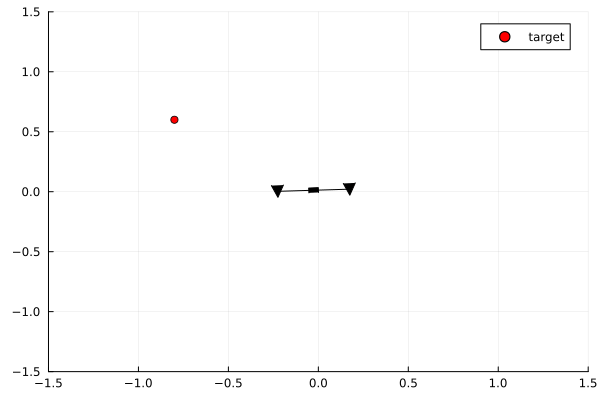

In [13]:
animate_drone(drone, target, results)

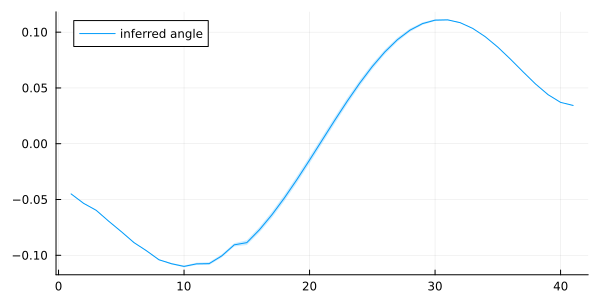

In [14]:
let 
    inferred_angle_mean = map(p -> mean(p)[5], results.posteriors[:s])
    inferred_angle_std  = map(p -> std(p)[5],  results.posteriors[:s])
    plot(inferred_angle_mean; ribbon = inferred_angle_std, fillalpha = 0.2, label = "inferred angle", size=(600,300))
end

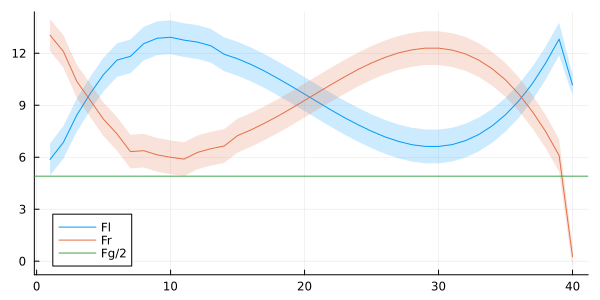

In [15]:
let 
    inferred_forces_mean = hcat(map(p -> mean(p), results.posteriors[:F])...)'
    inferred_forces_std  = hcat(map(p -> sqrt.(var(p)),  results.posteriors[:F])...)'
    plot(inferred_forces_mean[:,1]; ribbon = inferred_forces_std[:,1], fillalpha = 0.2, label = "Fl", size=(600,300))
    plot!(inferred_forces_mean[:,2]; ribbon = inferred_forces_std[:,2], fillalpha = 0.2, label = "Fr", size=(600,300))
    
    hline!([get_mass(drone) * get_gravity(env) / 2], label = "Fg/2")
end